Goals of this notebook:
* Introduce gradient descent intuition
* Play with learning rate
* Play with  initial condition
* Introduce Newton's method intuition
* Play with initial guess

Include references, maybe mention other themes in optmization
methods with links (stochastic GD, quasi-newton, CG, constrained, ???)

What are some of the popular options for learning models in sklearn?
Maybe give some brief info?
Explain why first-order methods more popular in ML
* Expensive to compute Hessian
* Even GD expensive for large models -> SGD

Choosing learning rate:
* trust-region vs. line-search
* learning rate schedule for SGD

Variance reduction for SGD

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

#%matplotlib notebook

In [2]:
def gradient_descent(x0, func, grad, step, tol=1e-6, max_iter=1000):
    """Minimize function with gradient descent.

    Parameters
    ----------
    x0 : array
        Starting point for solver.
    func : function
        Objective function to minimize.
    grad : function
        Gradient of objective function.
    step : float
        Step size for gradient step.
    tol : float, optional
        Gradient tolerance for terminating solver.
    max_iter : int, optional
        Maximum number of iterations for solver.

    Returns
    -------
    x : float
        Function minimizer.
    x_vals : array
        Iterates.
    func_vals : array
        Function values at iterates.
    grad_vals : array
        Norm of gradient at iterates.
    flag : int
        0, norm of gradient below `tol`.
        1, maximum number of iterations reached.

    """
    # Initialize return values
    if type(x0) in (int, float):
        x_vals = np.zeros((1, max_iter + 1))
    else:
        x_vals = np.zeros((len(x0), max_iter + 1))
    x_vals[:, 0] = x0
    func_vals = np.zeros(max_iter + 1)
    func_vals[0] = func(x0)
    grad_vals = np.zeros(max_iter + 1)
    grad_vals[0] = np.linalg.norm(grad(x0))

    # Minimize function
    for ii in range(1, max_iter + 1):
        x_vals[:, ii] = x_vals[:, ii - 1] - step*grad(x_vals[:, ii - 1])
        func_vals[ii] = func(x_vals[:, ii])
        grad_vals[ii] = np.linalg.norm(grad(x_vals[:, ii]))

        # Check convergence
        if grad_vals[ii] < tol:
            return x_vals[:, ii], x_vals[:, :(ii + 1)].squeeze(), \
                   func_vals[:(ii + 1)], grad_vals[:(ii + 1)], 0

    return x_vals[:, -1], x_vals.squeeze(), func_vals, grad_vals, 1


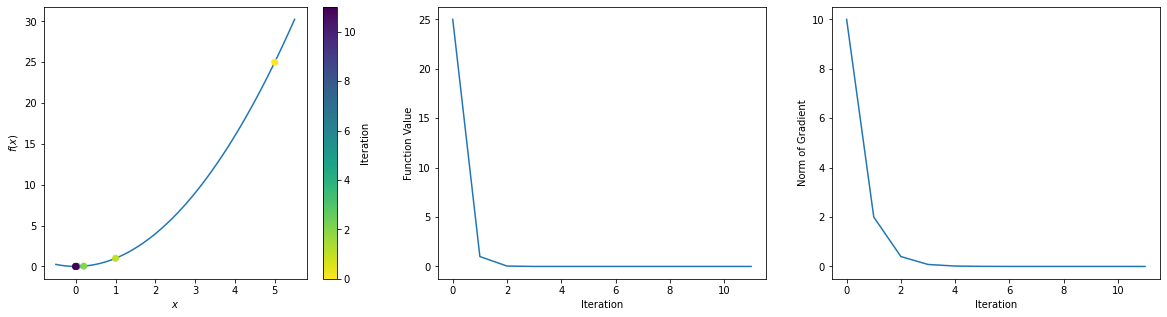

In [150]:
# Minimize function
x0 = 5
func = lambda x: x**2
grad = lambda x: 2*x
step = 0.4
results = gradient_descent(x0, func, grad, step)

# Try changing the step size in the range (0, 1] to see what happens.
# Are there any step sizes that can find the minimum in one step? (0.5)
# Are there any step sizes that result in a cycle? (1)
# What happens if the step size is too small?
# What happens if the step size is too big?

# Plot set up
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
cmap = 'viridis_r'
norm = plt.Normalize(0, len(results[1]) - 1)

# Plot iterates
pad = (max(results[1]) - min(results[1]))/10
x_vals = np.linspace(min(results[1]) - pad, max(results[1]) + pad)
ax[0].plot(x_vals, func(x_vals))
ax[0].scatter(results[1], results[2], c=np.arange(0, len(results[1])), zorder=3,
              cmap=cmap, norm=norm)
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$f(x)$')
fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm), label='Iteration', ax=ax[0])

# Plot function values
ax[1].plot(results[2])
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Function Value')

# Plot norm of gradient values
ax[2].plot(results[3])
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Norm of Gradient');

Number of iterations: 152
Number of iterations: 149
Number of iterations: 27


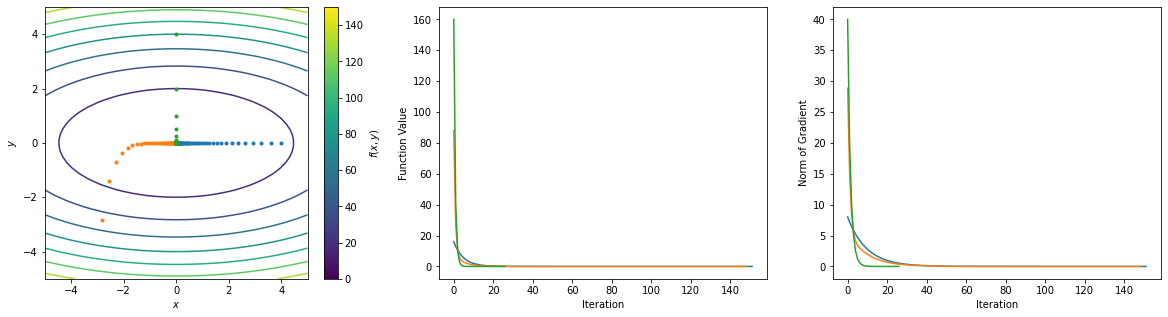

In [147]:
# 2D example
x_vals = np.linspace(-5, 5)
y_vals = np.linspace(-5, 5)
[X, Y] = np.meshgrid(x_vals, y_vals)

# Plot set up
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].contour(x_vals, y_vals, X**2 + 5*Y**2)
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$')
fig.colorbar(cm.ScalarMappable(norm=plt.Normalize(0, 150)), label='$f(x, y)$', ax=ax[0])
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Function Value')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Norm of Gradient')


# Set up problem
step = 0.05
func = lambda x: x[0]**2 + 10*x[1]**2
grad = lambda x: np.array([2*x[0], 10*x[1]])

# one step: 0.1
# cycle: 0.2

# Bad initial condition
results = gradient_descent([4, 0], func, grad, step)
ax[0].plot(results[1][0, :], results[1][1, :], '.')
ax[1].plot(results[2])
ax[2].plot(results[3])
print(f'Number of iterations: {len(results[2])}')

# Medium initial condition
results = gradient_descent([-2*np.sqrt(2), -2*np.sqrt(2)], func, grad, step)
ax[0].plot(results[1][0, :], results[1][1, :], '.')
ax[1].plot(results[2])
ax[2].plot(results[3])
print(f'Number of iterations: {len(results[2])}')

# Good initial condition
results = gradient_descent([0, 4], func, grad, step)
ax[0].plot(results[1][0, :], results[1][1, :], '.')
ax[1].plot(results[2])
ax[2].plot(results[3])
print(f'Number of iterations: {len(results[2])}')

# What's the difference between the initial conditions?
# Why does one converge in less iterations than the other?

# Try other initial conditions to see what happens...

In [110]:
def newtons_method(x0, func, grad, hess, tol=1e-6, max_iter=1000):
    """Minimize function with Newton's method.

    Parameters
    ----------
    x0 : array
        Starting point for solver.
    func : function
        Objective function to minimize.
    grad : function
        Gradient of objective function.
    hess : function
        Hessian of objective function.
    tol : float, optional
        Gradient tolerance for terminating solver.
    max_iter : int, optional
        Maximum number of iterations for solver.

    Returns
    -------
    x : float
        Function minimizer.
    x_vals : array
        Iterates.
    func_vals : array
        Function values at iterates.
    grad_vals : array
        Norm of gradient at iterates.
    flag : int
        0, norm of gradient below `tol`.
        1, maximum number of iterations reached.

    """
    # Initialize return values
    if type(x0) in (int, float):
        x_vals = np.zeros((1, max_iter + 1))
    else:
        x_vals = np.zeros((len(x0), max_iter + 1))
    x_vals[:, 0] = x0
    func_vals = np.zeros(max_iter + 1)
    func_vals[0] = func(x0)
    grad_vals = np.zeros(max_iter + 1)
    grad_vals[0] = np.linalg.norm(grad(x0))

    # Minimize function
    for ii in range(1, max_iter + 1):
        H = hess(x_vals[:, ii - 1])
        if type(H) in (int, float):
            x_vals[:, ii] = x_vals[:, ii - 1] - grad(x_vals[:, ii - 1])/H
        else:
            x_vals[:, ii] = x_vals[:, ii - 1] - np.linalg.solve(H, grad(x_vals[:, ii - 1]))
        func_vals[ii] = func(x_vals[:, ii])
        grad_vals[ii] = np.linalg.norm(grad(x_vals[:, ii]))

        # Check convergence
        if grad_vals[ii] < tol:
            return x_vals[:, ii], x_vals[:, :(ii + 1)].squeeze(), \
                   func_vals[:(ii + 1)], grad_vals[:(ii + 1)], 0

    return x_vals[:, -1], x_vals.squeeze(), func_vals, grad_vals, 1


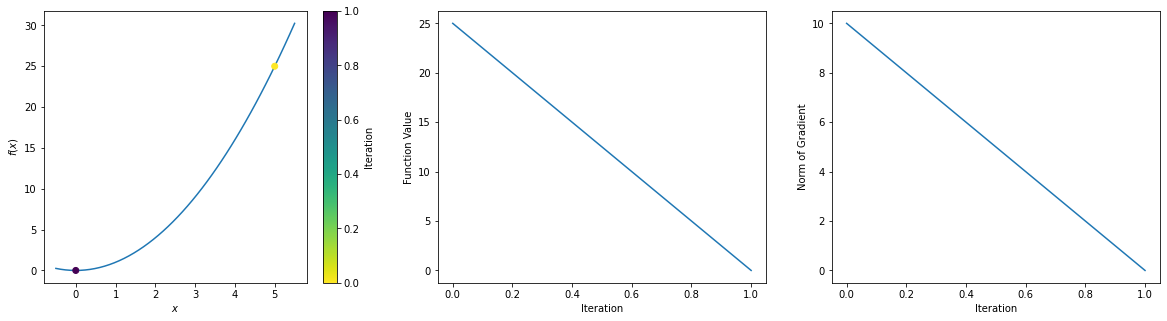

In [149]:
# Minimize function
x0 = 5
func = lambda x: x**2
grad = lambda x: 2*x
hess = lambda x: 2
results = newtons_method(x0, func, grad, hess)

# Step size 1/f'' gives us solution in one step, like we found with step size = 1/2 previously

# Plot set up
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
cmap = 'viridis_r'
norm = plt.Normalize(0, len(results[1]) - 1)

# Plot iterates
pad = (max(results[1]) - min(results[1]))/10
x_vals = np.linspace(min(results[1]) - pad, max(results[1]) + pad)
ax[0].plot(x_vals, func(x_vals))
ax[0].scatter(results[1], results[2], c=np.arange(0, len(results[1])), zorder=3,
              cmap=cmap, norm=norm)
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$f(x)$')
fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm), label='Iteration', ax=ax[0])

# Plot function values
ax[1].plot(results[2])
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Function Value')

# Plot norm of gradient values
ax[2].plot(results[3])
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Norm of Gradient');

Number of iterations: 2
Number of iterations: 2
Number of iterations: 2


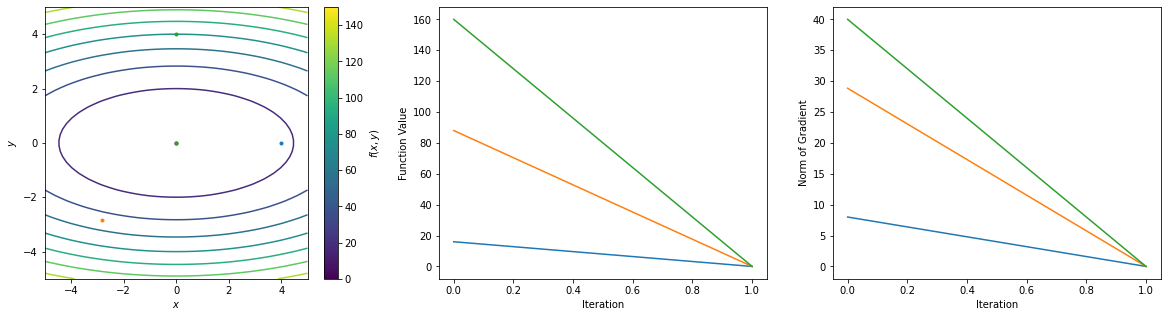

In [148]:
# 2D example
x_vals = np.linspace(-5, 5)
y_vals = np.linspace(-5, 5)
[X, Y] = np.meshgrid(x_vals, y_vals)

# Plot set up
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].contour(x_vals, y_vals, X**2 + 5*Y**2)
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$')
fig.colorbar(cm.ScalarMappable(norm=plt.Normalize(0, 150)), label='$f(x, y)$', ax=ax[0])
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Function Value')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Norm of Gradient')

# Set up problem
func = lambda x: x[0]**2 + 10*x[1]**2
grad = lambda x: np.array([2*x[0], 10*x[1]])
hess = lambda x: np.array([[2, 0], [0, 10]])

# wohoo, found one step for all!

# Bad initial condition
results = newtons_method([4, 0], func, grad, hess)
ax[0].plot(results[1][0, :], results[1][1, :], '.')
ax[1].plot(results[2])
ax[2].plot(results[3])
print(f'Number of iterations: {len(results[2])}')

# Medium initial condition
results = newtons_method([-2*np.sqrt(2), -2*np.sqrt(2)], func, grad, hess)
ax[0].plot(results[1][0, :], results[1][1, :], '.')
ax[1].plot(results[2])
ax[2].plot(results[3])
print(f'Number of iterations: {len(results[2])}')

# Good initial condition
results = newtons_method([0, 4], func, grad, hess)
ax[0].plot(results[1][0, :], results[1][1, :], '.')
ax[1].plot(results[2])
ax[2].plot(results[3])
print(f'Number of iterations: {len(results[2])}')